In [1]:
from io import StringIO

import pdfminer
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Perform layout analysis for all text
laparams = pdfminer.layout.LAParams()
setattr(laparams, 'all_texts', True)

def convert_pdf_to_text(file_path):
        
    output_string = StringIO()
    
    with open(file_path, 'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)

    return output_string.getvalue()

In [2]:
import glob
from tqdm import tqdm

file_names = glob.glob("src/*")
file_names[:5]

['src\\1.pdf', 'src\\10.pdf', 'src\\11.pdf', 'src\\12.pdf', 'src\\13.pdf']

In [3]:
from tqdm import tqdm

raw_text_extract_list = [convert_pdf_to_text(file_name) for file_name in tqdm(file_names)]

100%|██████████| 96/96 [07:10<00:00,  4.48s/it]


In [78]:
import pandas as pd
import numpy as np

# extract the timestamps of all publications

df_timestamp = pd.read_csv("bts_saner2023_timestamp.csv")
df_timestamp

,File_name,Timestamp
0,src\1.pdf,Apr-16
1,src\10.pdf,Nov-17
2,src\11.pdf,Jan-20
3,src\12.pdf,Aug-20
4,src\13.pdf,Aug-18
...,...,...
91,src\gs6.pdf,May-13
92,src\gs7.pdf,Mar-13
93,src\gs8.pdf,Feb-13
94,src\sc1.pdf,Aug-17


In [77]:
pd.reset_option('all')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



c:\users\biadge\appdata\local\programs\python\python37\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
c:\users\biadge\appdata\local\programs\python\python37\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [5]:
additional_stopwords = [
    "university",
    "copyright",
    "ieee",
    "research",
    "conference",
    "workshop",
    "international",
    "proceedings",
    "paper",
    "software",
    "traceability",
    "trace",
    "link",
    "introduction",
    "literature",
    "method",
    "methodology",
    "result",
    "conclusion",
    "discussion",
    "fig",
    "figure",
    "acknowledgement"
]

In [6]:
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nlp = spacy.load('en_core_web_md')

s_words = stopwords.words()

def run_text_processing(text):
    text = text.replace("\n"," ") # remove new line characters
    text = text.replace("cid"," ") # remove cid characters relating to non-unicode characters
    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', text) # keep only alphanumeric
    text = re.sub(' +', ' ', text) # remove multiple whitespaces
    text = text.lower() # convert all to lowercase
    
    text_tokens = word_tokenize(text) # tokenise text
    text_tokens = [word for word in text_tokens if not word in s_words] # remove stopwords
    text_tokens = [word for word in text_tokens if not word in additional_stopwords] # remove additional stopwords
    text_tokens = [word for word in text_tokens if (len(word) > 2 and not word.isdecimal())] # remove anything with 2 chars and below
    text_tokens = [word.lemma_ for word in nlp(" ".join(text_tokens))]
    
    return text_tokens

In [7]:
def remove_text_before_abstract(text):
    
    text = " ".join(text)
    
    if "abstract" in text:
        text_list = text.split("abstract")
    elif "a b s t r a c t" in text:
        text_list = text.split("a b s t r a c t")
    else:
        text_list = ["",text]
    
    return text_list[1]

In [8]:
text_extract_list = [run_text_processing(x) for x in tqdm(raw_text_extract_list)]

100%|██████████| 96/96 [02:47<00:00,  1.74s/it]


In [9]:
clean_text_extract_list = [remove_text_before_abstract(x) for x in tqdm(text_extract_list)]

100%|██████████| 96/96 [00:00<00:00, 2909.11it/s]


In [79]:
# pd.set_option('display.max_columns', None)
# pd.set_option('max_colwidth', None)

df = pd.DataFrame(np.transpose([file_names, clean_text_extract_list]), columns=['File_name', 'Text_extract'])
df = df.merge(df_timestamp, on='File_name')
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%b-%y", infer_datetime_format=True)
# df = df.sort_values(by='Timestamp', ignore_index=True, ascending=True)
df

,File_name,Text_extract,Timestamp
0,src\1.pdf,one major problem development process manage ...,Apr-16
1,src\10.pdf,recover link artifact requirement common task...,Nov-17
2,src\11.pdf,development devops practice widely use approa...,Jan-20
3,src\12.pdf,matter engineering community long time proces...,Aug-20
4,src\13.pdf,aim address problem incompleteness inconsiste...,Aug-18
...,...,...,...
91,src\gs6.pdf,large development project receive many bug re...,May-13
92,src\gs7.pdf,completely analyze closed issue report develo...,Mar-13
93,src\gs8.pdf,credit permit copy otherwise republish post s...,Feb-13
94,src\sc1.pdf,use case drive modularization improve code co...,Aug-17


In [11]:
df.to_csv("bts_saner2023_data.csv", encoding="utf-8", index=False)

## Start here to read csv file

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# pd.set_option('display.max_columns', None)
# pd.set_option('max_colwidth', None)


df = pd.read_csv("bts_saner2023_data.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%b-%y").dt.to_period('M')
df = df.sort_values('Timestamp').reset_index(drop=True)
df['Year'] = df['Timestamp'].dt.year
df

,File_name,Text_extract,Timestamp,Year
0,src\gs8.pdf,credit permit copy otherwise republish post s...,2013-02,2013
1,src\gs7.pdf,completely analyze closed issue report develo...,2013-03,2013
2,src\gs6.pdf,large development project receive many bug re...,2013-05,2013
3,src\gs5.pdf,automate requirement retrieval ontology use i...,2013-05,2013
4,src\gs4.pdf,information retrieval method partic ular topi...,2013-05,2013
...,...,...,...,...
91,src\45.pdf,automatic recovery artifact may promote early...,2021-07,2021
92,src\sp1.pdf,application programming interface api library...,2021-07,2021
93,src\63.pdf,architecture documentation often consist dif ...,2021-08,2021
94,src\52.pdf,information fundamental prereq uisite many es...,2021-09,2021


## EDA

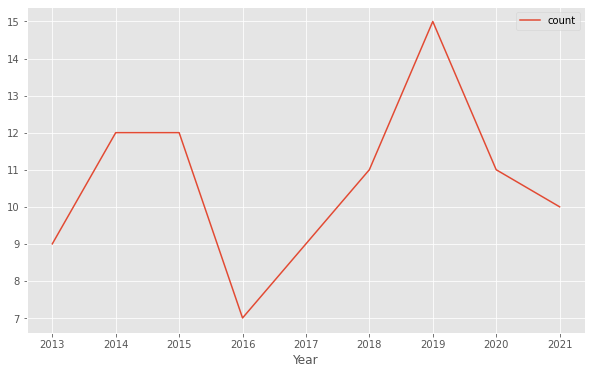

In [2]:
grouped_df = df.groupby('Year').size().to_frame("count").reset_index()

grouped_df.plot(kind='line', x='Year', y='count', figsize=(10,6))

In [3]:
grouped_df

,Year,count
0,2013,9
1,2014,12
2,2015,12
3,2016,7
4,2017,9
5,2018,11
6,2019,15
7,2020,11
8,2021,10


## TFIDF Vectorizer - unigram, bi-gram, tri-gram

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer_1 = TfidfVectorizer(ngram_range=(1,1), norm='l2')
vectorizer_2 = TfidfVectorizer(ngram_range=(2,2), norm='l2')
vectorizer_3 = TfidfVectorizer(ngram_range=(3,3), norm='l2')
vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2')

X_1 = vectorizer_1.fit_transform(df['Text_extract'])
X_2 = vectorizer_2.fit_transform(df['Text_extract'])
X_3 = vectorizer_3.fit_transform(df['Text_extract'])
X = vectorizer.fit_transform(df['Text_extract'])

features_1 = vectorizer_1.get_feature_names()
features_2 = vectorizer_2.get_feature_names()
features_3 = vectorizer_3.get_feature_names()
features = vectorizer.get_feature_names()

In [228]:
def top_n_tfidf_feats(row, features, top_n=100):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [229]:
def top_tfidf_feats(row, features):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    top_ids = np.argsort(row)[::-1][:]
    top_feats = [(features[i], row[i]) for i in top_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [271]:
def top_feats_in_doc(X, features, row_id):
    ''' Top tfidf features in specific doc (matrix row) '''
    row = np.squeeze(X[row_id].toarray())
    return top_n_tfidf_feats(row, features, top_n=100000)

In [115]:
def top_n_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=100):
    ''' Return the top n features that (in total) are most important amongst documents in rows
        identified by indices in grp_ids. '''
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_n_tfidf_feats(tfidf_means, features, top_n)

In [116]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1):
    ''' Return the top n features that on average are most important amongst documents in rows
        identified by indices in grp_ids. '''
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features)

In [117]:
def top_n_sum_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=100):
    ''' Return the top n features that (in total) are most important amongst documents in rows
        identified by indices in grp_ids. '''
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_sums = np.sum(D, axis=0)
    return top_n_tfidf_feats(tfidf_sums, features, top_n)

In [118]:
def top_sum_feats(X, features, grp_ids=None, min_tfidf=0.1):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_sums = np.sum(D, axis=0)
    return top_tfidf_feats(tfidf_sums, features)

In [119]:
def top_feats_by_year(X, y, features, min_tfidf=0.01, top_n=50000):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class year. '''
    dfs = []
    years = np.unique(y)
    for year in years:
        ids = np.where(y==year)
        feats_df = top_n_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.year = year
        dfs.append(feats_df)
    return dfs

In [120]:
dfs_1 = top_feats_by_year(X_1, df['Year'], features_1)
dfs_2 = top_feats_by_year(X_2, df['Year'], features_2)
dfs_3 = top_feats_by_year(X_3, df['Year'], features_3)
dfs = top_feats_by_year(X, df['Year'], features)

# remove 0 tfidf scores
dfs_1 = [df[df['tfidf']>0] for df in dfs_1]
dfs_2 = [df[df['tfidf']>0] for df in dfs_2]
dfs_3 = [df[df['tfidf']>0] for df in dfs_3]
dfs = [df[df['tfidf']>0] for df in dfs]

# set n-gram as id
dfs_1 = [df.set_index('feature') for df in dfs_1]
dfs_2 = [df.set_index('feature') for df in dfs_2]
dfs_3 = [df.set_index('feature') for df in dfs_3]
dfs = [df.set_index('feature') for df in dfs]

In [121]:
years = range(2013,2022)

In [122]:
ctr = 0

for year in years:
    dfs_1[ctr] = dfs_1[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

In [123]:
ctr = 0

for year in years:
    dfs_2[ctr] = dfs_2[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

In [124]:
ctr = 0

for year in years:
    dfs_3[ctr] = dfs_3[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

In [125]:
ctr = 0

for year in years:
    dfs[ctr] = dfs[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

### Unigram Ranking of Features - Year Trend

In [126]:
# pd.set_option('display.max_rows', None)

feats_df_1 = pd.concat(dfs_1, axis=1)
feats_df_1_sorted = feats_df_1.assign(Count_NA = lambda x: x.isnull().sum(axis=1)).sort_values('Count_NA', ascending=True).drop('Count_NA', axis=1)

feats_df_1_sorted

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
use,0.140934,0.115715,0.115312,0.069917,0.120139,0.108387,0.100884,0.098444,0.077427
increase,0.008162,0.002511,0.004905,0.004412,0.015218,0.009216,0.010029,0.005423,0.014373
future,0.001421,0.004990,0.005349,0.002007,0.004685,0.007636,0.006841,0.004651,0.003944
three,0.008318,0.015833,0.013707,0.012119,0.006455,0.009182,0.008800,0.003229,0.018355
java,0.008397,0.008299,0.003042,0.009162,0.011339,0.009629,0.008836,0.016247,0.002149
...,...,...,...,...,...,...,...,...,...
nanjing,NaN,NaN,NaN,NaN,0.002987,NaN,NaN,NaN,NaN
lens,NaN,NaN,NaN,NaN,0.002987,NaN,NaN,NaN,NaN
zxe,NaN,NaN,NaN,NaN,0.002987,NaN,NaN,NaN,NaN


In [127]:
req_feats_1 = feats_df_1_sorted[feats_df_1_sorted.index=='requirement']
req_feats_1.columns = [2013,2014,2015,2016,2017,2018,2019,2020,2021]
req_feats_1 = req_feats_1.transpose()
req_feats_1

feature,requirement
2013,0.052571
2014,0.086014
2015,0.099535
2016,0.098070
2017,0.080486
2018,0.119152
2019,0.116478
2020,0.070397
2021,0.074255


In [128]:
des_feats_1 = feats_df_1_sorted[feats_df_1_sorted.index=='design']
des_feats_1

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
design,0.002983,0.022742,0.013735,0.015069,0.027755,0.035564,0.022178,0.039399,0.02242


In [129]:
des_feats_1 = feats_df_1_sorted[feats_df_1_sorted.index=='design']
des_feats_1.columns = [2013,2014,2015,2016,2017,2018,2019,2020,2021]
des_feats_1 = des_feats_1.transpose()
des_feats_1

feature,design
2013,0.002983
2014,0.022742
2015,0.013735
2016,0.015069
2017,0.027755
2018,0.035564
2019,0.022178
2020,0.039399
2021,0.022420


In [130]:
reqdes_feats = pd.concat([req_feats_1,des_feats_1],axis=1)

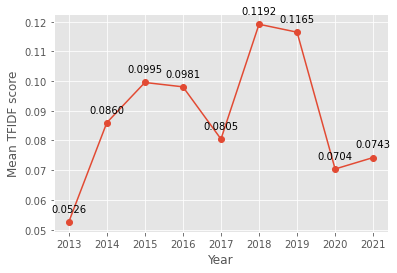

In [131]:
# req_feats_1[req_feats_1.index=='requirement'].transpose().plot(kind='line', figsize=(12,7),style='.-')

import matplotlib.pyplot as plt

plt.plot(req_feats_1,  marker='o')

plt.xlabel('Year')
plt.ylabel('Mean TFIDF score')

for x,y in zip(req_feats_1.index,req_feats_1['requirement']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

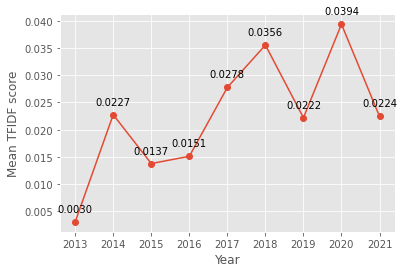

In [132]:
# req_feats_1[req_feats_1.index=='requirement'].transpose().plot(kind='line', figsize=(12,7),style='.-')

import matplotlib.pyplot as plt

plt.plot(des_feats_1,  marker='o')

plt.xlabel('Year')
plt.ylabel('Mean TFIDF score')

for x,y in zip(des_feats_1.index,des_feats_1['design']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

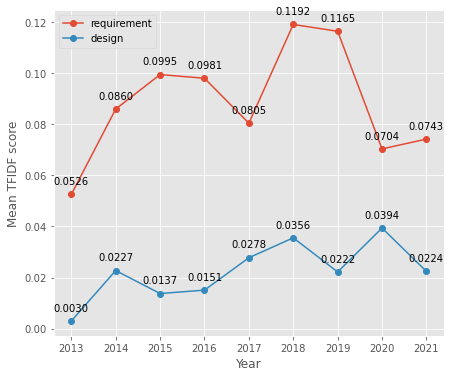

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(reqdes_feats,  marker='o')

plt.xlabel('Year')
plt.ylabel('Mean TFIDF score')

for x,y in zip(des_feats_1.index,des_feats_1['design']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(req_feats_1.index,req_feats_1['requirement']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(['requirement','design'])

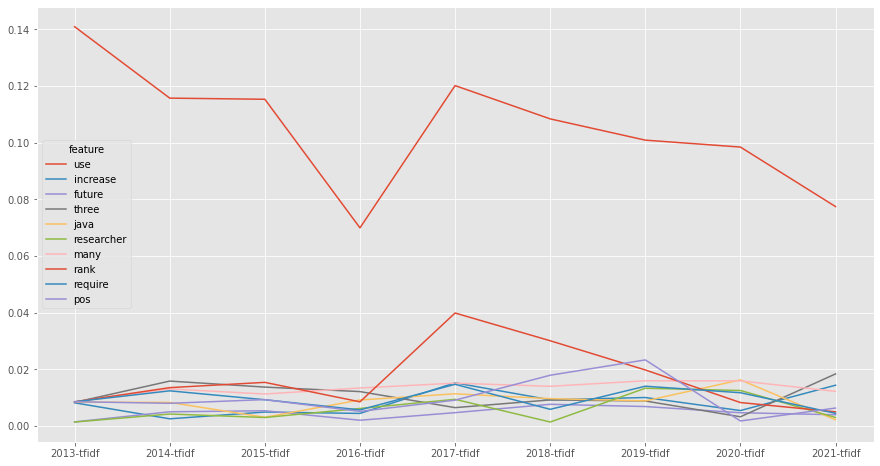

In [159]:
feats_df_1_sorted_sub = feats_df_1_sorted[:10]
# feats_df_1_sorted_sub = feats_df_1_sorted_sub.interpolate(axis=1)
feats_df_1_sorted_sub.transpose().plot(figsize=(15,8))

### Bi-gram Ranking of Features - Year Trend

In [160]:
# pd.set_option('display.max_rows', None)

feats_df_2 = pd.concat(dfs_2, axis=1)
feats_df_2_sorted = feats_df_2.assign(Count_NA = lambda x: x.isnull().sum(axis=1)).sort_values('Count_NA', ascending=True).drop('Count_NA', axis=1)

feats_df_2_sorted

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
information retrieval,0.013764,0.015010,0.012208,0.008913,0.020392,0.015287,0.014635,0.010945,0.010575
base approach,0.019815,0.000898,0.004917,0.012700,0.001461,0.004986,0.011775,0.005460,0.003071
use case,0.002947,0.001304,0.007813,0.008460,0.045674,0.001204,0.007746,0.007896,0.015211
textual information,0.020495,0.001093,0.003645,0.001603,0.003259,0.003571,0.003246,0.001846,0.010433
model vsm,0.002433,0.003916,0.002622,0.001488,0.005098,0.002435,0.003231,0.004076,0.001016
...,...,...,...,...,...,...,...,...,...
recall corr,NaN,NaN,0.000947,NaN,NaN,NaN,NaN,NaN,NaN
particularly evident,NaN,NaN,0.000947,NaN,NaN,NaN,NaN,NaN,NaN
hold report,NaN,NaN,0.000947,NaN,NaN,NaN,NaN,NaN,NaN


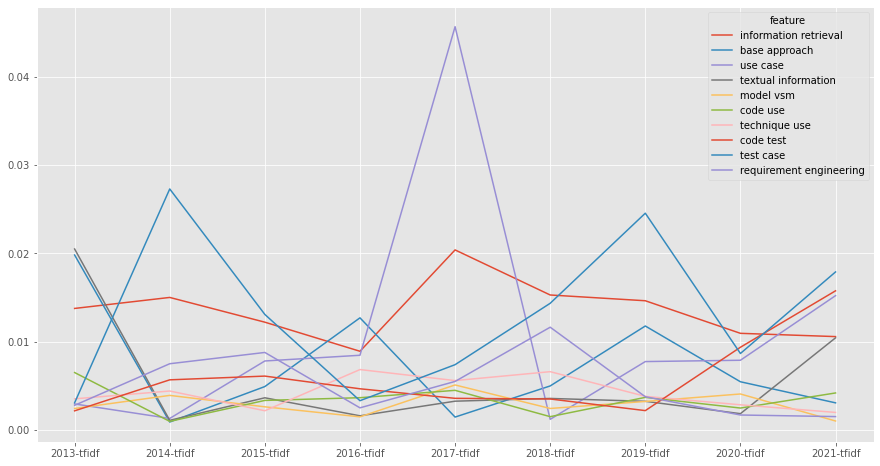

In [161]:
feats_df_2_sorted_sub = feats_df_2_sorted[:10]
feats_df_2_sorted_sub = feats_df_2_sorted_sub.interpolate(axis=1)
feats_df_2_sorted_sub.transpose().plot(figsize=(15,8))

In [162]:
feats_df_2_sorted_sub

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
information retrieval,0.013764,0.015010,0.012208,0.008913,0.020392,0.015287,0.014635,0.010945,0.010575
base approach,0.019815,0.000898,0.004917,0.012700,0.001461,0.004986,0.011775,0.005460,0.003071
use case,0.002947,0.001304,0.007813,0.008460,0.045674,0.001204,0.007746,0.007896,0.015211
textual information,0.020495,0.001093,0.003645,0.001603,0.003259,0.003571,0.003246,0.001846,0.010433
model vsm,0.002433,0.003916,0.002622,0.001488,0.005098,0.002435,0.003231,0.004076,0.001016
code use,0.006503,0.000972,0.003346,0.003655,0.004488,0.001507,0.003692,0.002483,0.004192
technique use,0.003526,0.004412,0.002177,0.006842,0.005593,0.006602,0.003807,0.002851,0.001986
code test,0.002167,0.005678,0.006101,0.004664,0.003583,0.003509,0.002192,0.009367,0.015759
test case,0.003080,0.027296,0.013084,0.003315,0.007395,0.014347,0.024550,0.008662,0.017898


### Tri-gram Ranking of Features - Year Trend

In [163]:
# pd.set_option('display.max_rows', None)

feats_df_3 = pd.concat(dfs_3, axis=1)
feats_df_3_sorted = feats_df_3.assign(Count_NA = lambda x: x.isnull().sum(axis=1)).sort_values('Count_NA', ascending=True).drop('Count_NA', axis=1)

feats_df_3_sorted

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
requirement source code,0.006530,0.003083,0.018482,0.004462,0.004121,0.002372,0.014813,0.005976,0.008967
source code test,0.002789,0.004977,0.006577,0.005407,0.004718,0.001106,0.001130,0.001890,0.003514
vector space model,0.002865,0.018149,0.012406,0.007214,0.008516,0.004923,0.004297,0.012908,NaN
mean average precision,0.003637,0.003896,0.000841,NaN,0.002947,0.003170,0.001904,0.002028,0.002265
latent dirichlet allocation,0.006310,0.004605,0.002496,NaN,0.001712,0.003945,0.002163,0.006809,0.001032
...,...,...,...,...,...,...,...,...,...
cation label describe,NaN,NaN,0.001148,NaN,NaN,NaN,NaN,NaN,NaN
cation keyword cluster,NaN,NaN,0.001148,NaN,NaN,NaN,NaN,NaN,NaN
learning vol slonim,NaN,NaN,0.001148,NaN,NaN,NaN,NaN,NaN,NaN


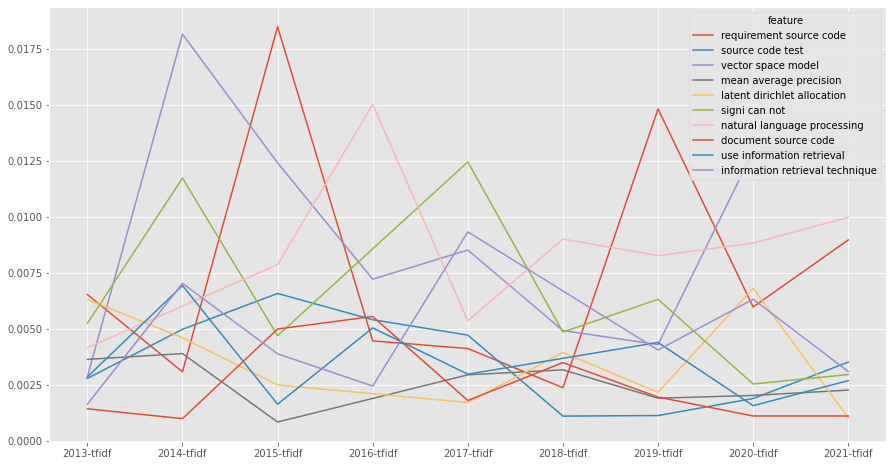

In [164]:
feats_df_3_sorted_sub = feats_df_3_sorted[:10]
feats_df_3_sorted_sub = feats_df_3_sorted_sub.interpolate(axis=1)
feats_df_3_sorted_sub.transpose().plot(figsize=(15,8))

## Embeddings - Dictionary filtering

In [165]:
# from gensim.models.wrappers import FastText

# model = FastText.load_fasttext_format('wiki.en.bin')

In [166]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec(glove_input_file="glove.6B.50d.txt", word2vec_output_file="glove.w2v.txt")

In [167]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("C:/Users/biadge/OneDrive - BP/PhD/extraction/SO_vectors_200.bin", binary=True)

In [168]:
unigram_feats = top_sum_feats(X_1, features_1)[:50]['feature'].tolist()
all_feats = top_sum_feats(X, features)[:50]['feature'].tolist()

In [169]:
from sklearn.decomposition import PCA

def display_pca_scatterplot(model, words, ranked=False):
    
    vec_list = []
    
    for w in words:
        try:
            vec_list.append(model[w])
        except:
            continue
    
    word_vectors = np.array(vec_list)
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    
    x = twodim[:,0]
    y = twodim[:,1]
    
    plt.scatter(x, y)
    
    for i in range(len(x)):
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    plt.show()

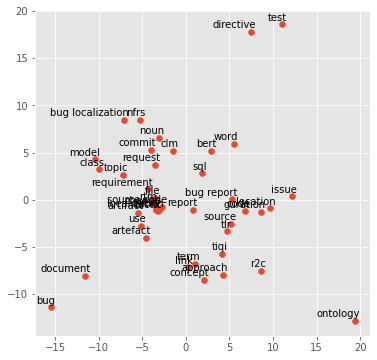

In [170]:
display_pca_scatterplot(model, all_feats)

In [171]:
from sklearn.manifold import TSNE

In [172]:
def display_tsne_scatterplot(model, words, ranked=False):

    labels = []
    tokens = []
    
#     if not ranked:
#         words = words[1:]

    for w in words:
        
        try:
            tokens.append(model[w])
            labels.append(w)
        except:
            continue
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=48)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    if ranked:
        pass
    
    plt.show()

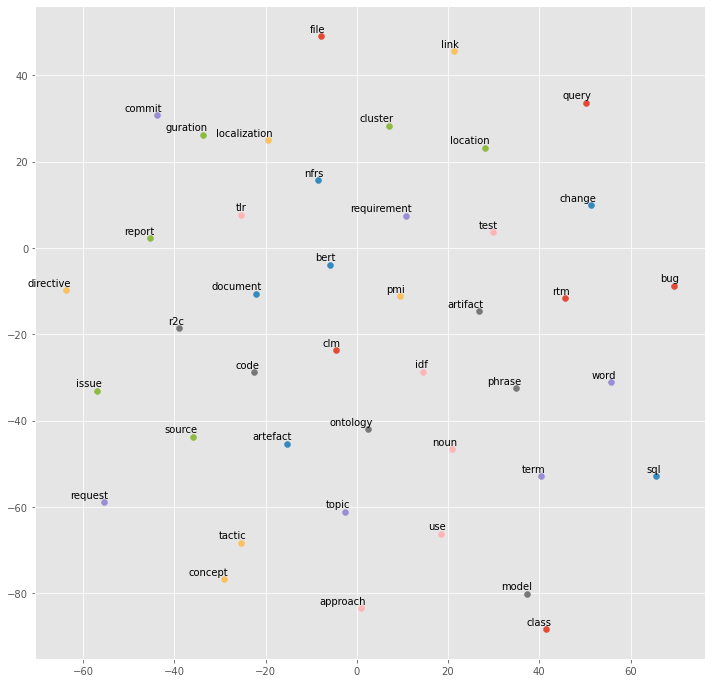

In [173]:
display_tsne_scatterplot(model,all_feats)

### Nearest points for word vectors input

In [174]:
feats_sum_df = top_sum_feats(X, features)
feats_mean_df = top_mean_feats(X, features)
feats_sum_df = feats_sum_df[feats_sum_df['tfidf']>0]
feats_mean_df = feats_mean_df[feats_mean_df['tfidf']>0]

In [175]:
feats_df = feats_sum_df.merge(feats_mean_df, on='feature', suffixes=('_sum', '_mean'))
feats_df[:10]

,feature,tfidf_sum,tfidf_mean
0,bug,3.483791,0.036289
1,artefact,3.080143,0.032085
2,requirement,3.057882,0.031853
3,code,2.173192,0.022637
4,link,2.134217,0.022231
5,bug report,2.105101,0.021928
6,report,1.714327,0.017858
7,use,1.419150,0.014783
8,rtm,1.212945,0.012635
9,bert,1.184370,0.012337


In [176]:
feats_df.to_csv("feats_df.csv", index=False)

In [177]:
def get_cos_sim(x, model, word):
    try:
        res = model.similarity(x, word)
    except:
        res = 0
    return res

In [178]:
get_cos_sim('report', model, 'bug')

0.17773233

In [179]:
def top_n_ranked_terms(df, model, word_input, top_n=20):

    df['similarity'] = df['feature'].apply(lambda x: get_cos_sim(x, model, word_input))
    df['similarity'] = df['similarity'].map(lambda x: '{0:.6f}'.format(x))
    df = df.sort_values('similarity', ascending=False).reset_index(drop=True)
    
    return df[:top_n]

## User input: requirement

In [180]:
ranked_req_feats_df = top_n_ranked_terms(feats_df, model, 'requirement', 21)
ranked_req_feats_df[1:11]

,feature,tfidf_sum,tfidf_mean,similarity
1,hipaa,0.442741,0.004612,0.414685
2,regulation,0.100489,0.001047,0.407030
3,constraint,0.146712,0.001528,0.381385
4,recommendation,0.111513,0.001162,0.376611
5,design,0.127999,0.001333,0.341189
6,feature,0.317932,0.003312,0.340356
7,concept,1.062280,0.011065,0.336251
8,architecture,0.409237,0.004263,0.333967
9,case,0.260482,0.002713,0.321802
10,knowledge,0.115704,0.001205,0.310221


In [181]:
model.most_similar(positive=['healthcare','requirement'], negative=[], topn=10, restrict_vocab=None)

[('requirements', 0.7149343490600586),
 ('regulatory', 0.6758537292480469),
 ('regulations', 0.6599622964859009),
 ('regulation', 0.6577485799789429),
 ('government', 0.6470068693161011),
 ('telecommunication', 0.6358578205108643),
 ('medical', 0.626889705657959),
 ('ehr', 0.6245075464248657),
 ('telecom', 0.6242926120758057),
 ('demands', 0.6223253011703491)]

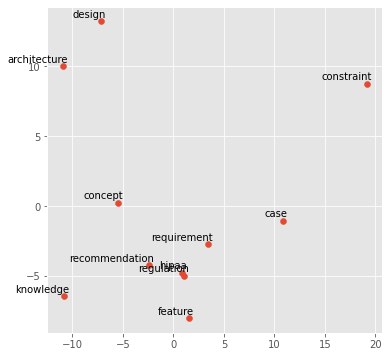

In [182]:
display_pca_scatterplot(model, ranked_req_feats_df['feature'].tolist()[0:11], ranked=True)

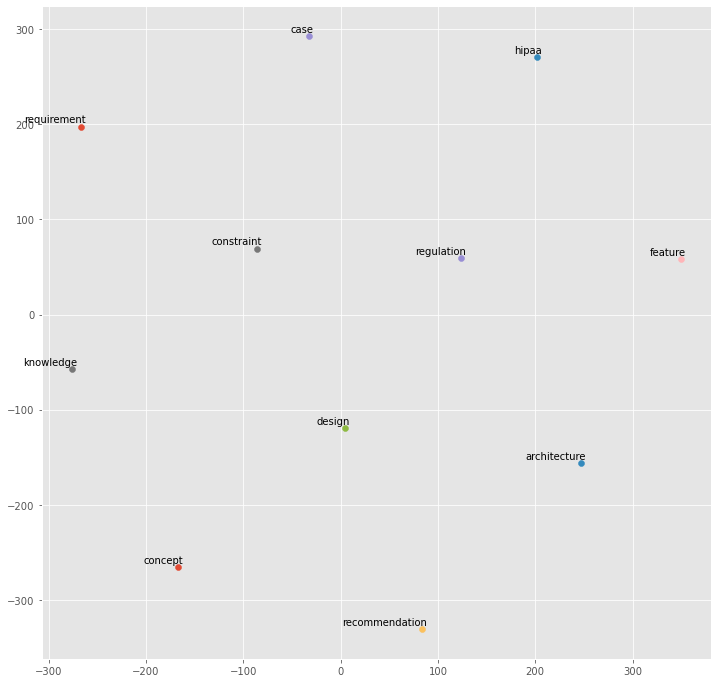

In [183]:
display_tsne_scatterplot(model, ranked_req_feats_df['feature'].tolist()[0:11], ranked=True)

## User input: design

In [184]:
ranked_des_feats_df = top_n_ranked_terms(feats_df, model, 'design', 21)
ranked_des_feats_df[1:11]

,feature,tfidf_sum,tfidf_mean,similarity
1,architectural,0.389092,0.004053,0.699393
2,architecture,0.409237,0.004263,0.589876
3,modularization,0.188090,0.001959,0.518056
4,approach,0.771197,0.008033,0.481808
5,compositional,0.100985,0.001052,0.466911
6,concept,1.062280,0.011065,0.456808
7,uml,0.188263,0.001961,0.449373
8,functional,0.142391,0.001483,0.448855
9,consistency,0.348033,0.003625,0.447875
10,sdlc,0.103420,0.001077,0.433501


In [185]:
model.most_similar(positive=['healthcare','design'], negative=[], topn=10, restrict_vocab=None)

[('architects', 0.7192467451095581),
 ('designing', 0.6962529420852661),
 ('industry', 0.671805202960968),
 ('medical', 0.6660199761390686),
 ('technological', 0.663608193397522),
 ('economic', 0.663145899772644),
 ('regulatory', 0.6570987701416016),
 ('industrial', 0.6561939120292664),
 ('avionics', 0.6510810852050781),
 ('logistics', 0.6475102305412292)]

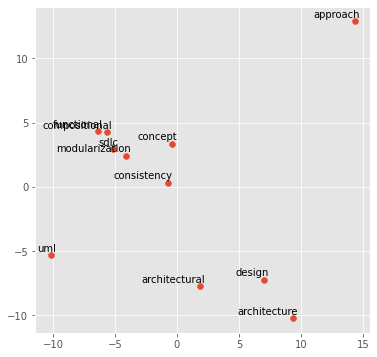

In [186]:
display_pca_scatterplot(model, ranked_des_feats_df['feature'].tolist()[0:11], ranked=True)

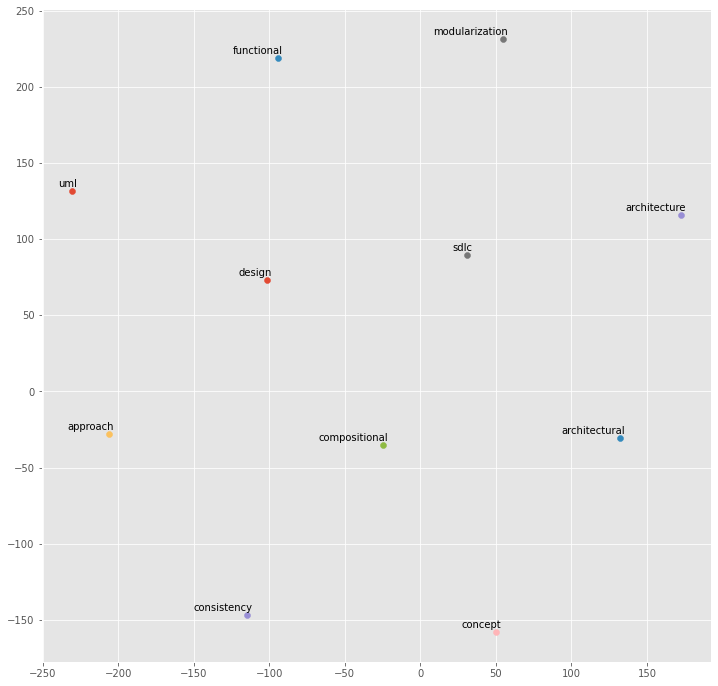

In [187]:
display_tsne_scatterplot(model, ranked_des_feats_df['feature'].tolist()[0:11], ranked=True)

# Time series matrix - requirement

In [272]:
df_meta_req = df.drop(columns=['Text_extract', 'Year', 'File_name'])

In [273]:
def get_term_tfidf(row, term):
    df = top_feats_in_doc(X, features, row)
    
    df = df[df['feature']==term]
    
    if df.empty:
        return None
    
    tfidf_score = df['tfidf'].tolist()[0]
    
    return tfidf_score

In [274]:
from tqdm import tqdm
term_req_tfidf_list = [get_term_tfidf(x, 'requirement') for x in tqdm(range(0,len(df_meta_req)))]

100%|██████████| 96/96 [00:16<00:00,  5.84it/s]


In [275]:
df_meta_req['requirement_tfidf_score'] = term_req_tfidf_list
df_meta_req = df_meta_req.groupby('Timestamp')['requirement_tfidf_score'].mean()
df_meta_req = df_meta_req.reset_index()
df_meta_req = df_meta_req.set_index('Timestamp', drop=True)
df_meta_req[:10]

,requirement_tfidf_score
Timestamp,
2013-02,0.003723
2013-03,0.007730
2013-05,0.031080
2013-07,0.027113
2013-09,0.119669
2013-10,0.123712
2014-01,0.059684
2014-03,0.001509
2014-04,0.055556


In [276]:
df_meta_req_inter = df_meta_req.interpolate(axis=0)
df_meta_req_inter = df_meta_req_inter.dropna()
df_meta_req_inter.index = df_meta_req_inter.index.astype("datetime64[ns]")
df_meta_req_inter[:10]

,requirement_tfidf_score
Timestamp,
2013-02-01,0.003723
2013-03-01,0.007730
2013-05-01,0.031080
2013-07-01,0.027113
2013-09-01,0.119669
2013-10-01,0.123712
2014-01-01,0.059684
2014-03-01,0.001509
2014-04-01,0.055556


In [277]:
df_meta_req_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2013-02-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   requirement_tfidf_score  66 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


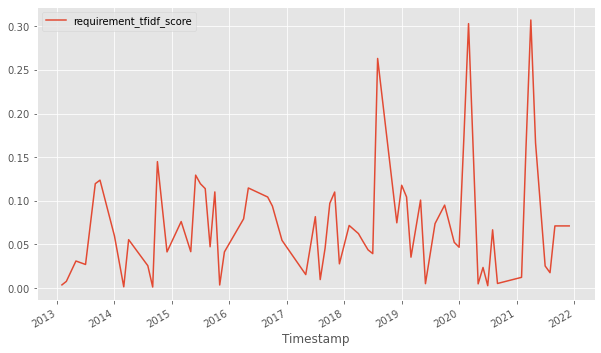

In [278]:
df_meta_req_inter.plot(kind='line', figsize=(10,6))

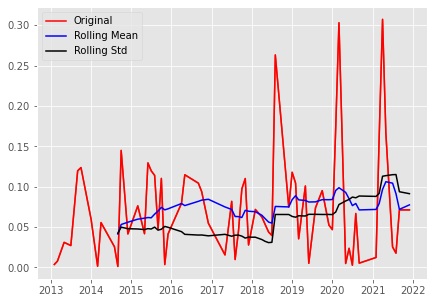

In [279]:
pd.plotting.register_matplotlib_converters()

ts_req = df_meta_req_inter['requirement_tfidf_score']
# plt.figure(figsize=(15,7))
fig = plt.figure(1)
plt.plot(df_meta_req_inter)

rollmean_req = ts_req.rolling(12).mean()
rollstd_req = ts_req.rolling(12).std()

orig_req = plt.plot(ts_req, color='red', label='Original')
mean_req = plt.plot(rollmean_req, color='blue', label='Rolling Mean')
std_req = plt.plot(rollstd_req, color='black', label='Rolling Std')
plt.legend(loc='best')

In [280]:
from statsmodels.tsa.stattools import adfuller

values_req = df_meta_req_inter['requirement_tfidf_score'].values
res_req = adfuller(values_req)

print('Augmented Dickey_fuller Statistic: %f' % res_req[0])
print('p-value: %f' % res_req[1])

print('critical values at different levels:')
for k, v in res_req[4].items():
    print('\t%s: %.3f' % (k, v))

Augmented Dickey_fuller Statistic: -5.580675
p-value: 0.000001
critical values at different levels:
	1%: -3.544
	5%: -2.911
	10%: -2.593


- ADF statistic is lower than the critical values at different levels
- p-value is also lower than 0.05
- we can reject our null hypothesis and conclude that our data is stationary.

In [281]:
df_meta_req_inter_sub = df_meta_req_inter.copy()
df_meta_req_inter_sub.index = pd.DatetimeIndex(df_meta_req_inter_sub.index).to_period('M')

In [282]:
df_meta_req_inter_sub[:10]

,requirement_tfidf_score
Timestamp,
2013-02,0.003723
2013-03,0.007730
2013-05,0.031080
2013-07,0.027113
2013-09,0.119669
2013-10,0.123712
2014-01,0.059684
2014-03,0.001509
2014-04,0.055556


In [283]:
ts_req_df = df_meta_req_inter_sub.reset_index(drop=True)
ts_req_df[:10]

,requirement_tfidf_score
0,0.003723
1,0.007730
2,0.031080
3,0.027113
4,0.119669
5,0.123712
6,0.059684
7,0.001509
8,0.055556
9,0.040624


In [284]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

ts_req_model = pm.auto_arima(ts_req_df.requirement_tfidf_score, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(ts_req_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-162.133, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-117.004, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-151.017, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-137.844, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-162.857, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-150.304, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-163.063, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-150.063, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-160.985, Time=0.60 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-168.260, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-172.046, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-168.921, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-170.337, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : 

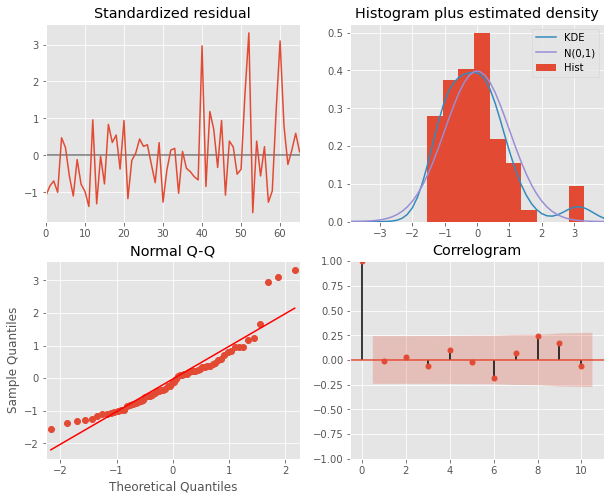

In [285]:
ts_req_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [286]:
ts_req_df

,requirement_tfidf_score
0,0.003723
1,0.007730
2,0.031080
3,0.027113
4,0.119669
...,...
61,0.166290
62,0.025393
63,0.017696
64,0.071279


In [287]:
from datetime import datetime

xticks_req_label = df_meta_req_inter.index.tolist()
to_append_req=(['2022-01-01',
          '2022-02-01',
          '2022-03-01',
          '2022-04-01',
          '2022-05-01',
          '2022-06-01',
          '2022-07-01',
          '2022-08-01',
          '2022-09-01',
          '2022-10-01',
          '2022-11-01',
          '2022-12-01',
          '2023-01-01',
          '2023-02-01',
          '2023-03-01',
          '2023-04-01',
          '2023-05-01',
          '2023-06-01',
          '2023-07-01',
          '2023-08-01',
          '2023-09-01',
          '2023-10-01',
          '2023-11-01',
          '2023-12-01'])

to_append_req_ts = [pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')) for x in to_append_req]

x_ticks_req_label = xticks_req_label+to_append_req_ts

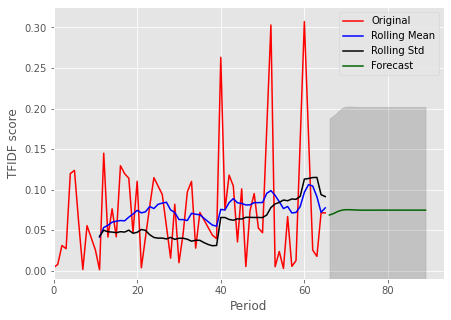

In [288]:
plt.rcParams['figure.figsize'] = [7, 5]

# Forecast
n_periods = 24
fc_req, confint_req = ts_req_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc_req = np.arange(len(ts_req_df.requirement_tfidf_score), len(ts_req_df.requirement_tfidf_score)+n_periods)

# make series for plotting purpose
fc_series_req = pd.Series(fc_req, index=index_of_fc_req)
lower_series_req = pd.Series(confint_req[:, 0], index=index_of_fc_req)
upper_series_req = pd.Series(confint_req[:, 1], index=index_of_fc_req)

# Plot
orig_req = plt.plot(ts_req_df.requirement_tfidf_score, color='red', label='Original')
plt.fill_between(lower_series_req.index, 
                 lower_series_req, 
                 upper_series_req, 
                 color='k', alpha=.15)

rollmean_req = ts_req_df.requirement_tfidf_score.rolling(12).mean()
rollstd_req = ts_req_df.requirement_tfidf_score.rolling(12).std()

mean_req = plt.plot(rollmean_req, color='blue', label='Rolling Mean')
std_req = plt.plot(rollstd_req, color='black', label='Rolling Std')
fc_req = plt.plot(fc_series_req, color='darkgreen', label='Forecast')

plt.xlabel("Period")
plt.ylabel("TFIDF score")
plt.legend(loc='best')

plt.ylim(ymin=-0.01)
plt.xlim(xmin=0)

# plt.xticks(np.arange(0, 89, step=1), xticks_label,  rotation='vertical')  # Set label locations.

plt.show()

In [289]:
fc_series_req

66    0.068672
67    0.070494
68    0.073034
69    0.074666
70    0.075239
71    0.075180
72    0.074928
73    0.074724
74    0.074628
75    0.074615
76    0.074636
77    0.074660
78    0.074674
79    0.074678
80    0.074676
81    0.074674
82    0.074672
83    0.074671
84    0.074671
85    0.074672
86    0.074672
87    0.074672
88    0.074672
89    0.074672
dtype: float64

In [290]:
lower_series_req

66   -0.050441
67   -0.050441
68   -0.050049
69   -0.051507
70   -0.052050
71   -0.052220
72   -0.052476
73   -0.052713
74   -0.052826
75   -0.052843
76   -0.052822
77   -0.052799
78   -0.052785
79   -0.052781
80   -0.052783
81   -0.052785
82   -0.052787
83   -0.052788
84   -0.052788
85   -0.052787
86   -0.052787
87   -0.052787
88   -0.052787
89   -0.052787
dtype: float64

In [291]:
upper_series_req

66    0.187784
67    0.191430
68    0.196116
69    0.200839
70    0.202527
71    0.202580
72    0.202333
73    0.202160
74    0.202083
75    0.202073
76    0.202095
77    0.202118
78    0.202132
79    0.202136
80    0.202135
81    0.202133
82    0.202131
83    0.202130
84    0.202130
85    0.202130
86    0.202131
87    0.202131
88    0.202131
89    0.202131
dtype: float64

# Time series matrix - design

In [292]:
df_meta_des = df.drop(columns=['Text_extract', 'Year', 'File_name'])

In [293]:
def get_term_tfidf(row, term):
    df = top_feats_in_doc(X, features, row)
    
    df = df[df['feature']==term]
    
    if df.empty:
        return None
    
    tfidf_score = df['tfidf'].tolist()[0]
    
    return tfidf_score

In [294]:
from tqdm import tqdm
term_des_tfidf_list = [get_term_tfidf(x, 'design') for x in tqdm(range(0,len(df_meta_des)))]

100%|██████████| 96/96 [00:16<00:00,  5.82it/s]


In [295]:
df_meta_des['design_tfidf_score'] = term_des_tfidf_list
df_meta_des = df_meta_des.groupby('Timestamp')['design_tfidf_score'].mean()
df_meta_des = df_meta_des.reset_index()
df_meta_des = df_meta_des.set_index('Timestamp', drop=True)
df_meta_des[:10]

,design_tfidf_score
Timestamp,
2013-02,NaN
2013-03,0.004166
2013-05,0.006561
2013-07,0.006495
2013-09,NaN
2013-10,0.002339
2014-01,0.010977
2014-03,0.001626
2014-04,0.002233


In [296]:
df_meta_des_inter = df_meta_des.interpolate(axis=0)
df_meta_des_inter = df_meta_des_inter.dropna()
df_meta_des_inter.index = df_meta_des_inter.index.astype("datetime64[ns]")
df_meta_des_inter[:10]

,design_tfidf_score
Timestamp,
2013-03-01,0.004166
2013-05-01,0.006561
2013-07-01,0.006495
2013-09-01,0.004417
2013-10-01,0.002339
2014-01-01,0.010977
2014-03-01,0.001626
2014-04-01,0.002233
2014-06-01,0.004579


In [297]:
df_meta_des_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2013-03-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   design_tfidf_score  65 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


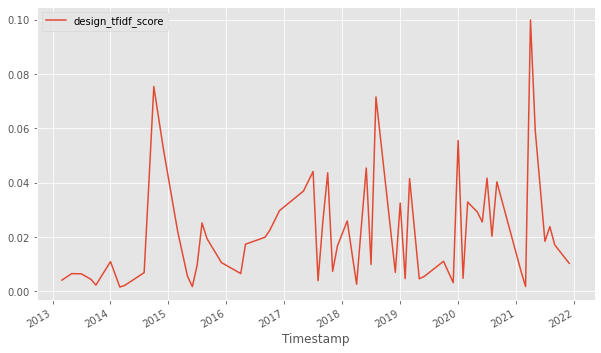

In [298]:
df_meta_des_inter.plot(kind='line', figsize=(10,6))

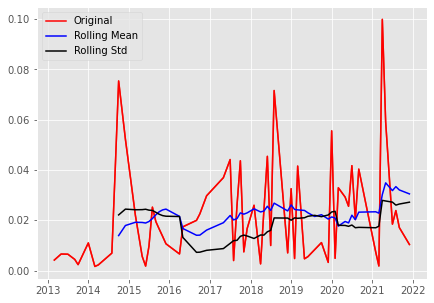

In [299]:
pd.plotting.register_matplotlib_converters()

ts_des = df_meta_des_inter['design_tfidf_score']
# plt.figure(figsize=(15,7))
fig = plt.figure(1)
plt.plot(df_meta_des_inter)

rollmean_des = ts_des.rolling(12).mean()
rollstd_des = ts_des.rolling(12).std()

orig_des = plt.plot(ts_des, color='red', label='Original')
mean_des = plt.plot(rollmean_des, color='blue', label='Rolling Mean')
std_des = plt.plot(rollstd_des, color='black', label='Rolling Std')
plt.legend(loc='best')

In [300]:
from statsmodels.tsa.stattools import adfuller

values_des = df_meta_des_inter['design_tfidf_score'].values
res_des = adfuller(values_des)

print('Augmented Dickey_fuller Statistic: %f' % res_des[0])
print('p-value: %f' % res_des[1])

print('critical values at different levels:')
for k, v in res_des[4].items():
    print('\t%s: %.3f' % (k, v))

Augmented Dickey_fuller Statistic: -6.835167
p-value: 0.000000
critical values at different levels:
	1%: -3.537
	5%: -2.908
	10%: -2.591


- ADF statistic is lower than the critical values at different levels
- p-value is also lower than 0.05
- we can reject our null hypothesis and conclude that our data is stationary.

In [301]:
df_meta_des_inter_sub = df_meta_des_inter.copy()
df_meta_des_inter_sub.index = pd.DatetimeIndex(df_meta_des_inter_sub.index).to_period('M')

In [302]:
df_meta_des_inter_sub[:10]

,design_tfidf_score
Timestamp,
2013-03,0.004166
2013-05,0.006561
2013-07,0.006495
2013-09,0.004417
2013-10,0.002339
2014-01,0.010977
2014-03,0.001626
2014-04,0.002233
2014-06,0.004579


In [303]:
ts_des_df = df_meta_des_inter_sub.reset_index(drop=True)
ts_des_df[:10]

,design_tfidf_score
0,0.004166
1,0.006561
2,0.006495
3,0.004417
4,0.002339
5,0.010977
6,0.001626
7,0.002233
8,0.004579
9,0.006924


In [304]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

ts_des_model = pm.auto_arima(ts_des_df.design_tfidf_score, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(ts_des_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-312.405, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-271.134, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-298.115, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-285.594, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-311.417, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-311.301, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-291.264, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-303.272, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-308.594, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-316.111, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-317.835, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-318.641, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-317.994, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.186 seconds
                      

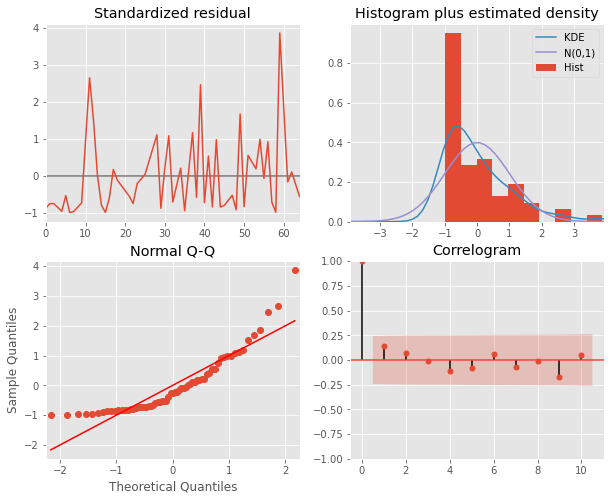

In [305]:
ts_des_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [306]:
ts_des_df

,design_tfidf_score
0,0.004166
1,0.006561
2,0.006495
3,0.004417
4,0.002339
...,...
60,0.059148
61,0.018432
62,0.023844
63,0.017099


In [307]:
from datetime import datetime

xticks_des_label = df_meta_des_inter.index.tolist()
to_append_des=(['2022-01-01',
          '2022-02-01',
          '2022-03-01',
          '2022-04-01',
          '2022-05-01',
          '2022-06-01',
          '2022-07-01',
          '2022-08-01',
          '2022-09-01',
          '2022-10-01',
          '2022-11-01',
          '2022-12-01',
          '2023-01-01',
          '2023-02-01',
          '2023-03-01',
          '2023-04-01',
          '2023-05-01',
          '2023-06-01',
          '2023-07-01',
          '2023-08-01',
          '2023-09-01',
          '2023-10-01',
          '2023-11-01',
          '2023-12-01'])

to_append_des_ts = [pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')) for x in to_append_des]

x_ticks_des_label = xticks_des_label+to_append_des_ts

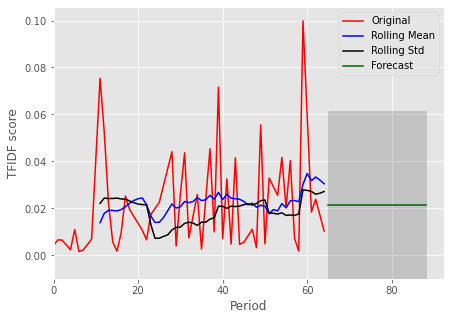

In [308]:
plt.rcParams['figure.figsize'] = [7, 5]

# Forecast
n_periods = 24
fc_des, confint_des = ts_des_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc_des = np.arange(len(ts_des_df.design_tfidf_score), len(ts_des_df.design_tfidf_score)+n_periods)

# make series for plotting purpose
fc_series_des = pd.Series(fc_des, index=index_of_fc_des)
lower_series_des = pd.Series(confint_des[:, 0], index=index_of_fc_des)
upper_series_des = pd.Series(confint_des[:, 1], index=index_of_fc_des)

# Plot
orig_des = plt.plot(ts_des_df.design_tfidf_score, color='red', label='Original')
plt.fill_between(lower_series_des.index, 
                 lower_series_des, 
                 upper_series_des, 
                 color='k', alpha=.15)

rollmean_des = ts_des_df.design_tfidf_score.rolling(12).mean()
rollstd_des = ts_des_df.design_tfidf_score.rolling(12).std()

mean_des = plt.plot(rollmean_des, color='blue', label='Rolling Mean')
std_des = plt.plot(rollstd_des, color='black', label='Rolling Std')
fc_des = plt.plot(fc_series_des, color='darkgreen', label='Forecast')

plt.xlabel("Period")
plt.ylabel("TFIDF score")
plt.legend(loc='best')

plt.ylim(ymin=-0.01)
plt.xlim(xmin=0)

# plt.xticks(np.arange(0, 89, step=1), xticks_label,  rotation='vertical')  # Set label locations.

plt.show()

In [309]:
fc_series_des

65    0.021612
66    0.021612
67    0.021612
68    0.021612
69    0.021612
70    0.021612
71    0.021612
72    0.021612
73    0.021612
74    0.021612
75    0.021612
76    0.021612
77    0.021612
78    0.021612
79    0.021612
80    0.021612
81    0.021612
82    0.021612
83    0.021612
84    0.021612
85    0.021612
86    0.021612
87    0.021612
88    0.021612
dtype: float64

In [310]:
lower_series_des

65   -0.018029
66   -0.018029
67   -0.018029
68   -0.018029
69   -0.018029
70   -0.018029
71   -0.018029
72   -0.018029
73   -0.018029
74   -0.018029
75   -0.018029
76   -0.018029
77   -0.018029
78   -0.018029
79   -0.018029
80   -0.018029
81   -0.018029
82   -0.018029
83   -0.018029
84   -0.018029
85   -0.018029
86   -0.018029
87   -0.018029
88   -0.018029
dtype: float64

In [311]:
upper_series_des

65    0.061254
66    0.061254
67    0.061254
68    0.061254
69    0.061254
70    0.061254
71    0.061254
72    0.061254
73    0.061254
74    0.061254
75    0.061254
76    0.061254
77    0.061254
78    0.061254
79    0.061254
80    0.061254
81    0.061254
82    0.061254
83    0.061254
84    0.061254
85    0.061254
86    0.061254
87    0.061254
88    0.061254
dtype: float64